## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# A 9*6 chessboard - 
# 9 in x and 6 in y direction
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

test_img = cv2.imread(images[0])
img_size = (test_img.shape[1], test_img.shape[0])

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

## Test Camera Calibration...

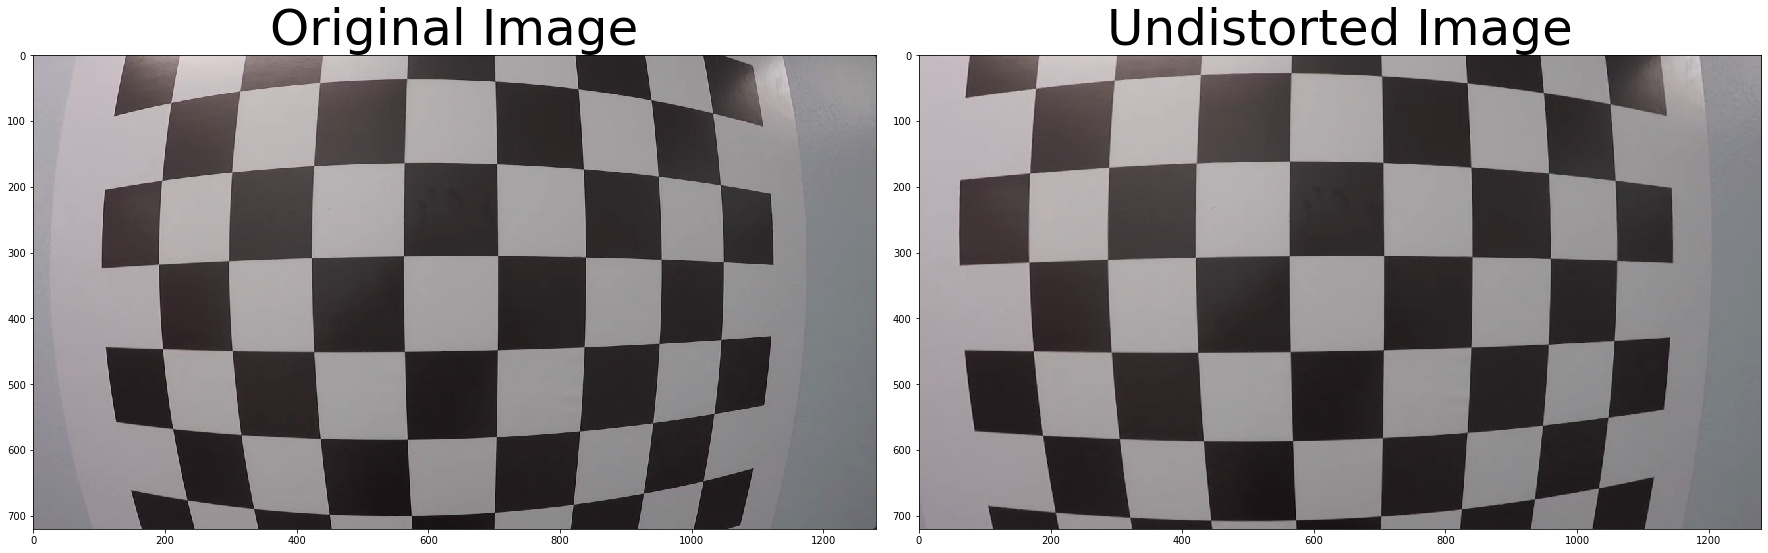

In [13]:
test_img = cv2.imread('calibration_test.png')
undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Identifying Transformation Matrix for Perspective Transform

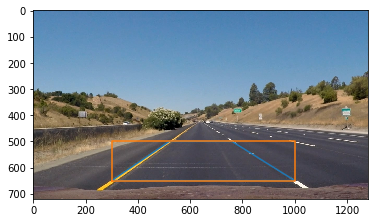

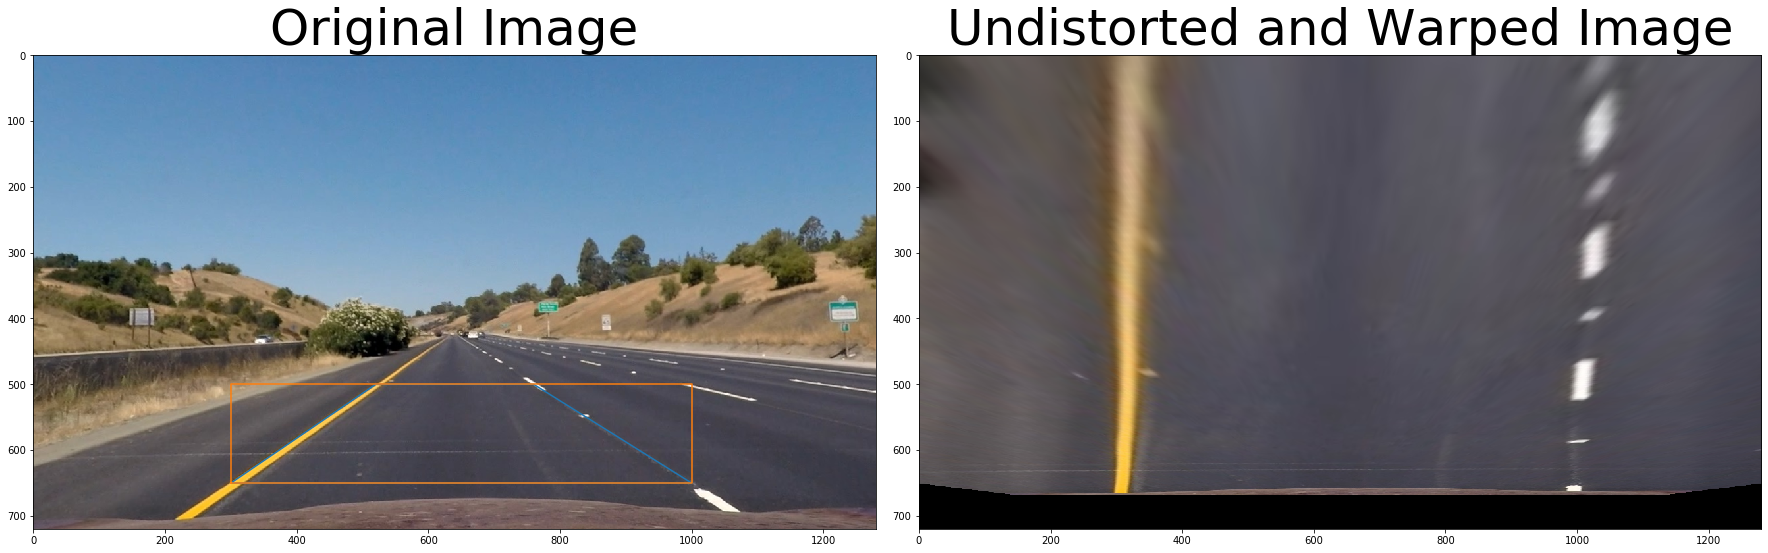

In [16]:
test_img = mpimg.imread('../test_images/straight_lines1.jpg')
plt.imshow(test_img)

test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

src = np.float32([[300, 650], [1000, 650], [760,500], [520,500]])
dest = np.float32([[300, 650], [1000, 650], [1000,500], [300,500]])
# src = np.float32([[300, 650], [1000, 650], [680,450], [595,450]])
# dest = np.float32([[300, 650], [1000, 650], [1000,450], [300,450]])


plt.plot(list(src[:,0])+[src[0,0]], list(src[:,1])+[src[0,1]])
plt.plot(list(dest[:,0])+[dest[0,0]], list(dest[:,1])+[dest[0,1]])

M = cv2.getPerspectiveTransform(src, dest)
warped = cv2.warpPerspective(test_undist, M, img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_undist)
ax1.plot(list(src[:,0])+[src[0,0]], list(src[:,1])+[src[0,1]])
ax1.plot(list(dest[:,0])+[dest[0,0]], list(dest[:,1])+[dest[0,1]])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test Perspective Transform on Curved Lines

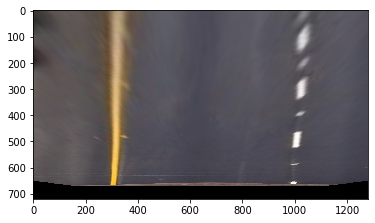

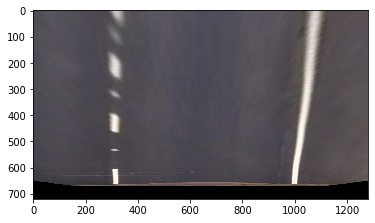

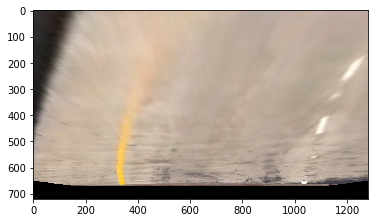

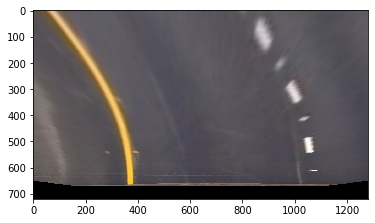

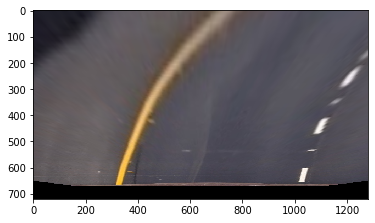

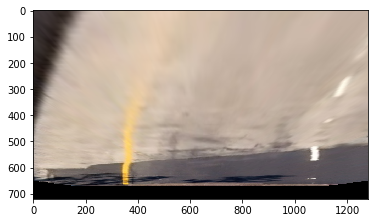

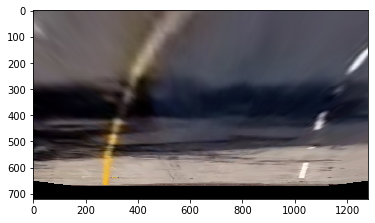

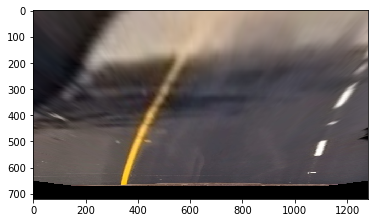

In [17]:
imagenames = glob.glob('../test_images/*.jpg')
for name in imagenames:
    img = mpimg.imread(name)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)
    plt.imshow(warped)
    plt.pause(1.5)

In [45]:
def apply_transform(img, M, img_size):
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

In [83]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    return sobel_binary

In [30]:
def s_channel_thresh(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=thresh[0]) & (s_channel<=thresh[1])] = 1
    return s_binary

In [104]:
def mask_image(img):
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    imshape = img.shape
    vertices = np.array([[(165,imshape[0]),(435, 310), (600, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
#     plt.imshow(masked_img)
    return masked_img

In [123]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # good_left_inds = binary_warped[win_y_low:win_y_high+1, win_xleft_low:win_xleft_high+1].nonzero()[1] + win_xleft_low
        # good_right_inds = binary_warped[win_y_low:win_y_high+1, win_xright_low:win_xright_high+1].nonzero()[1] + win_xright_low
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            # leftx_current = np.int(np.mean(good_left_inds))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            # rightx_current = np.int(np.mean(good_right_inds))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [142]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit

In [143]:
def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    out_img, ploty, left_fit, right_fit = fit_polynomial(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

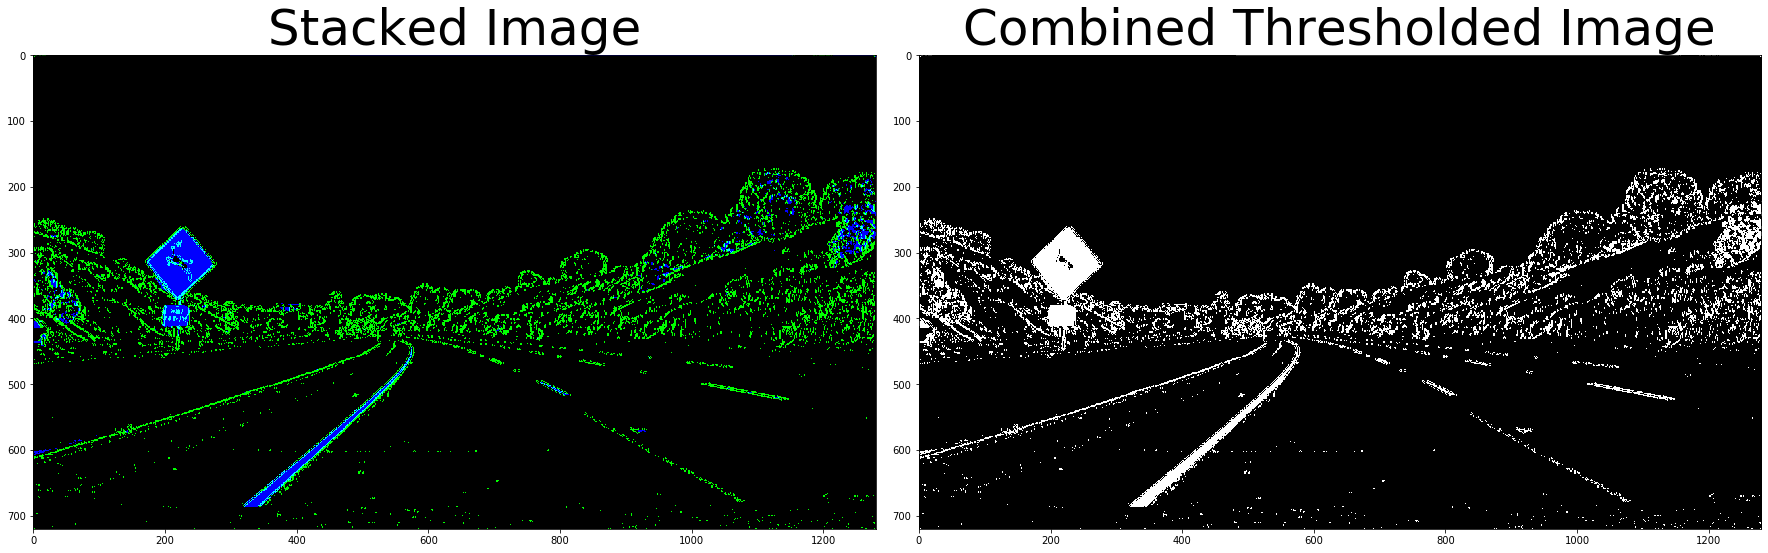

In [148]:
img = mpimg.imread('../test_images/test2.jpg')
# plt.imshow(test_img)
sobel_binary = abs_sobel_thresh(img, 'x', 5, (20,90))
s_binary = s_channel_thresh(img, (150,255))
combined_binary = np.zeros_like(s_binary)
combined_binary[(s_binary==1) | (sobel_binary==1)] = 1
color_binary = np.dstack(( np.zeros_like(s_binary), sobel_binary, s_binary)) * 255

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Stacked Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

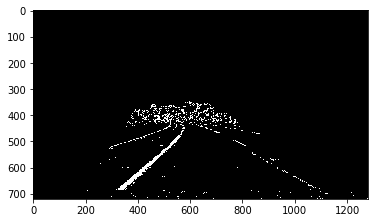

In [149]:
masked = mask_image(combined_binary)
plt.imshow(masked, cmap='gray')

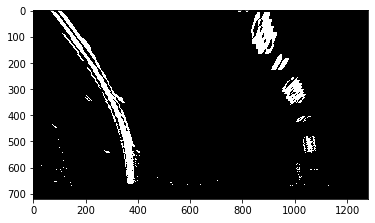

In [150]:
warped = apply_transform(combined_binary, M, img_size)
plt.imshow(warped, cmap='gray')

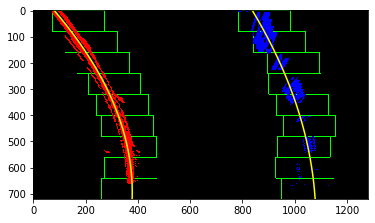

In [153]:
out_img, ploty, left_fit, right_fit = fit_polynomial(warped)
plt.imshow(out_img)

811.5488964920414 1353.567460713821


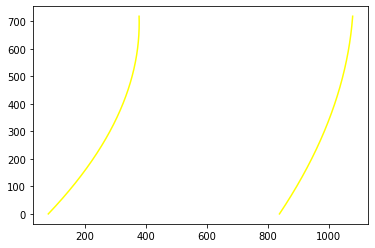

In [152]:
left_curverad, right_curverad = measure_curvature_pixels(warped)
print(left_curverad, right_curverad)